<a href="https://colab.research.google.com/github/lottle2008/MOOCCube-Transformer-Recommendation/blob/main/gai_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ==========================
# ✅ 适配真实数据集的代码（ASSISTments 2017）
# 基于指定路径和真实列名修改（支持批量读取多文件）
# ==========================

import pandas as pd
import numpy as np
import os
from google.colab import drive

# --------------------------
# 1️⃣ 挂载Google Drive（访问数据集）
# --------------------------
print("🔗 挂载Google Drive以访问数据集...")
drive.mount('/content/drive')
print("✅ Drive挂载完成")

# --------------------------
# 2️⃣ 读取数据集（批量读取多个文件）
# --------------------------
# 数据集所在文件夹路径（修改为你的实际文件夹路径）
DATASET_FOLDER = "/content/drive/MyDrive/gai/data/"  # 文件夹路径，包含所有student_log_x.csv

print("\n📂 批量读取数据集...")

# 生成所有文件名（student_log_1到student_log_5.csv）
file_names = [f"student_log_{i}.csv" for i in range(1, 6)]  # 生成1-5的文件列表
file_paths = [os.path.join(DATASET_FOLDER, name) for name in file_names]  # 拼接完整路径

# 循环读取所有文件并合并
dfs = []  # 存储每个文件的DataFrame
for path in file_paths:
    try:
        df_single = pd.read_csv(path)
        dfs.append(df_single)
        print(f"已读取: {os.path.basename(path)}，数据量: {len(df_single):,}")
    except FileNotFoundError:
        print(f"⚠️ 警告：文件不存在 - {path}")

# 合并数据并检查
if not dfs:
    raise ValueError("❌ 未读取到任何数据，请检查文件路径或文件是否存在！")

df = pd.concat(dfs, ignore_index=True)  # 合并所有数据，重置索引
print(f"\n合并后总数据量: {len(df):,}")

# --------------------------
# 3️⃣ 数据预处理（使用真实列名映射）
# 核心列映射关系：
# 原逻辑列名 → 真实数据集列名
# user_id → ITEST_id（学生唯一标识）
# problem_id → problemId（题目ID）
# skill_id → skill（知识点名称）
# correct → correct（答题正确性）
# order_id → actionId（交互顺序ID）
# --------------------------

# 保留关键列（使用真实列名）
df = df[['ITEST_id', 'problemId', 'skill', 'correct', 'actionId']]

# 剔除关键列缺失的记录
df = df.dropna(subset=['ITEST_id', 'problemId', 'skill'])
print(f"剔除缺失值后的数据量: {len(df):,}")

# 限制规模：取前5000个用户（便于Colab训练）
selected_users = df['ITEST_id'].unique()[:5000]
df = df[df['ITEST_id'].isin(selected_users)]
print(f"限制前5000用户后的数据量: {len(df):,}")

# 映射为字符串ID（避免数值型ID被误处理）
df['ITEST_id'] = df['ITEST_id'].astype(str)
df['problemId'] = df['problemId'].astype(str)
df['skill'] = df['skill'].astype(str)  # 知识点名称转为字符串

# --------------------------
# 4️⃣ 生成目标文件结构（与原逻辑对齐）
# --------------------------
os.makedirs("data", exist_ok=True)  # 创建data文件夹（若已存在则忽略）

# users.csv（用户表）
users = pd.DataFrame({'user_id': df['ITEST_id'].unique()})
users.to_csv("data/users.csv", index=False)

# videos.csv（题目表，模拟视频节点）
videos = pd.DataFrame({'video_id': df['problemId'].unique()})
videos.to_csv("data/videos.csv", index=False)

# video_concept_edges.csv（题目—知识点映射）
video_concept = df[['problemId', 'skill']].drop_duplicates()
video_concept.columns = ['video_id', 'concept_id']  # 重命名为模型需要的列名
video_concept.to_csv("data/video_concept_edges.csv", index=False)

# watch_logs.csv（用户—题目交互日志）
logs = df[['ITEST_id', 'problemId', 'correct', 'actionId']]
logs.columns = ['user_id', 'video_id', 'is_correct', 'timestamp']  # 适配模型字段
logs.to_csv("data/watch_logs.csv", index=False)

# --------------------------
# 5️⃣ 输出结果检查
# --------------------------
print("\n✅ 数据文件已生成，共包含：")
for f in os.listdir("data"):
    file_path = os.path.join("data", f)
    print(f" - {f}: {len(pd.read_csv(file_path)):,} 条记录")

🔗 挂载Google Drive以访问数据集...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive挂载完成

📂 批量读取数据集...
已读取: student_log_1.csv，数据量: 231,403


/tmp/ipython-input-1871726431.py:34: DtypeWarning: Columns (74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  df_single = pd.read_csv(path)


已读取: student_log_2.csv，数据量: 365,839
已读取: student_log_3.csv，数据量: 37,160
已读取: student_log_4.csv，数据量: 30,659
已读取: student_log_5.csv，数据量: 66,726

合并后总数据量: 731,787
剔除缺失值后的数据量: 731,787
限制前5000用户后的数据量: 731,787

✅ 数据文件已生成，共包含：
 - videos.csv: 3,921 条记录
 - watch_logs.csv: 731,787 条记录
 - users.csv: 1,165 条记录
 - video_concept_edges.csv: 3,961 条记录


Phase 0｜环境、种子、设备、工具函数

解决的问题：

统一随机种子（复现实验）

设备检测（GPU 优先）

通用 EarlyStopping、学习率调度器

评价指标（Recall/NDCG/Hit-Rate/AUC/MRR）与日志工具

In [7]:
# ====== 环境 & 工具函数（Phase 0 保持不变） ======
import os, random, math, json, time, gc
import numpy as np
import pandas as pd
from collections import defaultdict
from typing import List, Dict, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(2025)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

PROJECT_ROOT = "/content/drive/MyDrive/gai"
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
os.makedirs(DATA_DIR, exist_ok=True)

class EarlyStopping:
    def __init__(self, patience=5, mode="min", delta=0.0):
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None
    def __call__(self, score, model=None):
        improve = False
        if self.best_score is None:
            improve = True
        else:
            if self.mode == "min":
                improve = score < self.best_score - self.delta
            else:
                improve = score > self.best_score + self.delta
        if improve:
            self.best_score = score
            self.counter = 0
            if model is not None:
                self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def recall_at_k(y_true, y_pred_ranked, k):
    return len(y_true.intersection(set(y_pred_ranked[:k]))) / max(1, len(y_true))
def dcg_at_k(y_true, y_pred_ranked, k):
    dcg = 0.0
    for i, item in enumerate(y_pred_ranked[:k], 1):
        if item in y_true:
            dcg += 1.0 / math.log2(i + 1)
    return dcg
def ndcg_at_k(y_true, y_pred_ranked, k):
    ideal_hits = min(len(y_true), k)
    idcg = sum(1.0 / math.log2(i + 1) for i in range(1, ideal_hits + 1))
    if idcg == 0: return 0.0
    return dcg_at_k(y_true, y_pred_ranked, k) / idcg
def hit_rate_at_k(y_true, y_pred_ranked, k):
    return 1.0 if len(y_true.intersection(set(y_pred_ranked[:k]))) > 0 else 0.0
def mrr_at_k(y_true, y_pred_ranked, k):
    for i, item in enumerate(y_pred_ranked[:k], 1):
        if item in y_true:
            return 1.0 / i
    return 0.0
def binary_auc(pos_score, neg_scores):
    greater = sum(pos_score > ns for ns in neg_scores)
    ties = sum(pos_score == ns for ns in neg_scores)
    n = len(neg_scores)
    if n == 0: return 0.5
    return (greater + 0.5 * ties) / n
def save_json(obj, path):
    with open(path, "w") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)


Device: cuda


In [8]:
# ==========================
# ✅ 生成 user_sequences.npy（适配 ASSISTments 2017 数据）
# 从 watch_logs.csv 构建用户行为序列
# ==========================

import pandas as pd
import numpy as np
import os
import json

DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

watch_log_path = os.path.join(DATA_DIR, "watch_logs.csv")
assert os.path.exists(watch_log_path), f"❌ 未找到文件: {watch_log_path}"

print(f"📘 加载交互日志: {watch_log_path}")
logs = pd.read_csv(watch_log_path)

# 确保列名正确
expected_cols = {"user_id", "video_id", "timestamp"}
assert expected_cols.issubset(set(logs.columns)), f"日志列名错误，需包含 {expected_cols}"

# 排序（按时间）
logs = logs.sort_values(by=["user_id", "timestamp"])

# 去重（同用户同视频多次交互，只保留一次）
logs = logs.drop_duplicates(subset=["user_id", "video_id"])

# 分组生成序列
user_sequences = []
for uid, group in logs.groupby("user_id"):
    items = group["video_id"].astype(str).tolist()
    if len(items) < 2:
        continue  # 跳过交互太少的用户
    user_sequences.append({"user_id": str(uid), "pos_items": items})

print(f"✅ 构建完毕: {len(user_sequences)} 个用户序列。")
np.save(os.path.join(DATA_DIR, "user_sequences.npy"), user_sequences)
print(f"💾 已保存: {os.path.join(DATA_DIR, 'user_sequences.npy')}")

# 检查一个样本
print("示例:", user_sequences[0])


📘 加载交互日志: /content/data/watch_logs.csv
✅ 构建完毕: 1165 个用户序列。
💾 已保存: /content/data/user_sequences.npy
示例: {'user_id': '8', 'pos_items': ['104051118', '104051119', '104051120', '104051121', '104051088', '104051089', '104051090', '104051091', '104051092', '104051074', '104051204', '104051205', '104051206', '104051207', '104051182', '104051183', '104051184', '104051185', '104051186', '104051093', '104051094', '104051095', '104051096', '104051097', '104051098', '104051099', '104051100', '104051101', '104051122', '104051125', '104051126', '104051113', '104051215', '104051216', '104051217', '104051218', '104051231', '104051232', '104051233', '104051077', '104051078', '104051079', '104051080', '104051081', '104051082', '104051160', '104051066', '104051190', '104051174', '104051175', '104051176', '104050673', '104050674', '104050675', '104050676', '104050667', '104050668', '104050677', '104050672', '104050662', '104050665', '104050663', '104050664', '104050669', '104050670', '104050666', '1040506

Phase 1｜数据增强：滑动窗口 + 更强负采样

完善内容：

在你原来的 user_sequences.npy 基础上增强训练样本：

用滑动窗口从长序列里多切出训练片段（缓解稀疏）。

时间加权近邻（近期行为权重大）。

语义负采样：优先抽取与正样本相似度高的负样本（更难学，提升判别边界）。

输出：train_pairs.npy（三元组 (u, pos, neg)），item_freq.json（召回时可用）。

这一步：

滑动窗口极大增加训练对（缓解欠拟合）。

（可选）语义负采样为后续排序学习提供更难的负样本（若你提供好 item 向量与索引对齐，替换上面注释处即可）。

In [9]:
# ==========================
# ✅ Phase 1: Build Sliding-Window Samples & Hard Negatives （改进版）
# 保证编号映射(user2idx/item2idx) 与 Phase 2 构图保持一致
# ==========================

import numpy as np
import os, json, random
from collections import Counter

# ---- 路径设置 ----
DATA_DIR = "/content/data"  # 统一路径

# ---- 加载用户行为序列 ----
seq_path = os.path.join(DATA_DIR, "user_sequences.npy")
assert os.path.exists(seq_path), f"Missing {seq_path}"
user_seqs = np.load(seq_path, allow_pickle=True)
print(f"📘 加载用户行为序列，共 {len(user_seqs)} 条。")

# ====================================================
# 1️⃣ 映射文件检查：优先使用已存在的 user2idx/item2idx
# ====================================================
user2idx_path = os.path.join(DATA_DIR, "user2idx.json")
item2idx_path = os.path.join(DATA_DIR, "item2idx.json")

if os.path.exists(user2idx_path) and os.path.exists(item2idx_path):
    # 已存在映射文件（来自 Phase 2 或早期）
    user2idx = json.load(open(user2idx_path))
    item2idx = json.load(open(item2idx_path))
    print(f"✅ 已加载现有映射：用户 {len(user2idx)}，物品 {len(item2idx)}")
else:
    # 未检测到映射文件 → 新建编号
    print("⚠️ 未检测到现有映射，重新生成 user2idx.json 与 item2idx.json。")
    users = []
    items = set()
    for rec in user_seqs:
        users.append(str(rec["user_id"]))
        for it in rec["pos_items"]:
            items.add(str(it))
    users = sorted(set(users))
    items = sorted(items)
    user2idx = {u:i for i,u in enumerate(users)}
    item2idx = {it:i for i,it in enumerate(items)}
    # 保存映射文件
    os.makedirs(DATA_DIR, exist_ok=True)
    with open(user2idx_path, "w") as f: json.dump(user2idx, f, indent=2)
    with open(item2idx_path, "w") as f: json.dump(item2idx, f, indent=2)
    print(f"✅ 已保存新映射文件：用户 {len(users)}，物品 {len(items)}")

# ====================================================
# 2️⃣ 生成物品流行度统计（用于随机负采样加权）
# ====================================================
from collections import Counter
pop_counter = Counter()
for rec in user_seqs:
    for it in rec["pos_items"]:
        pop_counter[str(it)] += 1
item_freq = {str(it): int(pop_counter.get(str(it), 0)) for it in item2idx.keys()}
with open(os.path.join(DATA_DIR, "item_freq.json"), "w") as f:
    json.dump(item_freq, f, indent=2)
print(f"📊 物品流行度统计完成，共 {len(item_freq)} 个条目。")

# ====================================================
# 3️⃣ 加载物品嵌入（若存在，用于语义负采样）
# ====================================================
item_emb_path = os.path.join(DATA_DIR, "item_model_embs.npy")
item_emb = None
if os.path.exists(item_emb_path):
    raw_item_emb = np.load(item_emb_path)
    dim = raw_item_emb.shape[1]
    item_emb = np.random.normal(0, 0.01, (len(item2idx), dim)).astype(np.float32)
    print(f"✅ 检测到 item_model_embs.npy，维度 {dim}，将启用语义负采样。")
else:
    print("ℹ️ 未检测到 item_model_embs.npy，采用随机负采样。")

# ====================================================
# 4️⃣ 滑动窗口生成训练样本
# ====================================================
WINDOW = 50   # 序列窗口长度
STRIDE = 5    # 滑动步长
pairs = []

all_item_idx = list(range(len(item2idx)))
all_item_set = set(all_item_idx)

for rec in user_seqs:
    uid_raw = str(rec["user_id"])
    if uid_raw not in user2idx:
        continue
    u = user2idx[uid_raw]
    seq = [item2idx[str(it)] for it in rec["pos_items"] if str(it) in item2idx]
    if len(seq) < 2:
        continue

    for end in range(1, len(seq)):
        start = max(0, end - WINDOW)
        hist = seq[start:end]
        pos = seq[end]

        # 负样本选择
        if item_emb is None:
            # 随机负采样（排除历史和当前正样本）
            cand = list(all_item_set - set(hist) - {pos})
            if not cand: continue
            neg = random.choice(cand)
        else:
            # （保留语义采样结构）默认用随机负采样
            neg_pool = list(all_item_set - set(hist) - {pos})
            if not neg_pool: continue
            neg = random.choice(neg_pool)

        pairs.append((u, pos, neg))

print(f"✅ 生成训练样本: {len(pairs):,} 条。")

# ====================================================
# 5️⃣ 保存输出文件
# ====================================================
np.save(os.path.join(DATA_DIR, "train_pairs.npy"), np.array(pairs, dtype=np.int32))
print(f"💾 已保存: train_pairs.npy ({len(pairs)} triples)")

print("\n🎯 Phase 1 已完成：生成映射 + 训练样本 + 负采样信息。")


📘 加载用户行为序列，共 1165 条。
⚠️ 未检测到现有映射，重新生成 user2idx.json 与 item2idx.json。
✅ 已保存新映射文件：用户 1165，物品 3921
📊 物品流行度统计完成，共 3921 个条目。
ℹ️ 未检测到 item_model_embs.npy，采用随机负采样。
✅ 生成训练样本: 293,463 条。
💾 已保存: train_pairs.npy (293463 triples)

🎯 Phase 1 已完成：生成映射 + 训练样本 + 负采样信息。


Phase 2｜GCN：更长训练 + EarlyStopping + 学习率调度

完善内容：

训练轮次从 10→50+，加入 EarlyStopping（监控验证损失）

学习率调度（ReduceLROnPlateau）

节点嵌入标准化保存（便于下游对齐）

这里给一个轻量 GCN版本（不依赖 PyG），输入 edge_index，可与你现有构图代码直接对接。若你已有 GCN 代码，只需把训练循环替换为这里的版本即可。

这一步：更强的 GCN 训练 + 规范化输出，便于后续与序列表征对齐。

Phase 2｜GCN：使用 PyTorch Geometric 的完整实现

修改目的：采用标准 GCNConv 层（而非自定义简单平均聚合），更稳健、更模块化、适合异构图大规模训练。也更接近研究用图神经网络的“完整实现”。

In [10]:
import torch
print(torch.__version__)
!nvcc --version | grep release


2.8.0+cu126
Cuda compilation tools, release 12.5, V12.5.82


In [11]:
# 卸载旧版本，避免冲突
!pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -y

# 安装 PyG 及依赖（匹配 Torch 2.8.0 + CUDA 12.1）
!pip install torch_geometric -f https://data.pyg.org/whl/torch-2.8.0+cu121.html


Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.0 MB/s eta 0:00:00


In [12]:
# ==========================
# ✅ 统一编号的图结构构建脚本（适配ASSISTments 2017 + Phase 1）
# 目标输出：edge_index.npy + n_nodes.json
# ==========================

import pandas as pd
import numpy as np
import os, json

# --------------------------
# 路径设置（与上一步保持一致）
# --------------------------
DATA_DIR = "/content/data"  # 你的数据集路径
OUT_DIR = DATA_DIR  # 输出同路径
os.makedirs(OUT_DIR, exist_ok=True)

# --------------------------
# 1️⃣ 加载基础文件
# --------------------------
video_concept_path = os.path.join(DATA_DIR, "video_concept_edges.csv")
watch_logs_path = os.path.join(DATA_DIR, "watch_logs.csv")
users_path = os.path.join(DATA_DIR, "users.csv")
videos_path = os.path.join(DATA_DIR, "videos.csv")

for path in [video_concept_path, watch_logs_path, users_path, videos_path]:
    assert os.path.exists(path), f"❌ 缺少文件: {path}"

vc_df = pd.read_csv(video_concept_path)
wl_df = pd.read_csv(watch_logs_path)
users_df = pd.read_csv(users_path)
videos_df = pd.read_csv(videos_path)

print(f"✅ 读取完成: 用户 {len(users_df)}, 题目 {len(videos_df)}, 交互 {len(wl_df)}, 概念映射 {len(vc_df)}")

# --------------------------
# 2️⃣ 检查 Phase 1 生成的映射文件（若存在则直接加载）
# --------------------------
user2idx_path = os.path.join(DATA_DIR, "user2idx.json")
item2idx_path = os.path.join(DATA_DIR, "item2idx.json")

if os.path.exists(user2idx_path) and os.path.exists(item2idx_path):
    user2idx = json.load(open(user2idx_path))
    video2idx = json.load(open(item2idx_path))
    print(f"✅ 已加载 Phase 1 映射: 用户 {len(user2idx)}, 视频 {len(video2idx)}")
else:
    print("⚠️ 未检测到 Phase 1 输出映射，重新生成编号。")
    user_ids = sorted(users_df["user_id"].astype(str).unique())
    video_ids = sorted(videos_df["video_id"].astype(str).unique())
    user2idx = {u: i for i, u in enumerate(user_ids)}
    video2idx = {v: i for i, v in enumerate(video_ids)}
    json.dump(user2idx, open(user2idx_path, "w"), indent=2)
    json.dump(video2idx, open(item2idx_path, "w"), indent=2)
    print(f"✅ 已生成 user2idx.json & item2idx.json")

# --------------------------
# 3️⃣ 概念节点统一编号（连续接在视频节点之后）
# --------------------------
concept_ids = sorted(vc_df["concept_id"].astype(str).unique())
concept_offset = len(user2idx) + len(video2idx)
concept2idx = {c: i + concept_offset for i, c in enumerate(concept_ids)}

# --------------------------
# 4️⃣ 构造图的边关系（无向图）
# --------------------------
edges = []

# （1）用户–视频边
for _, row in wl_df.iterrows():
    u_raw = str(row["user_id"])
    v_raw = str(row["video_id"])
    if u_raw not in user2idx or v_raw not in video2idx:
        continue
    u = user2idx[u_raw]
    v = video2idx[v_raw] + len(user2idx)  # 视频节点整体偏移
    edges.append((u, v))
    edges.append((v, u))

# （2）视频–概念边
for _, row in vc_df.iterrows():
    v_raw = str(row["video_id"])
    c_raw = str(row["concept_id"])
    if v_raw not in video2idx or c_raw not in concept2idx:
        continue
    v = video2idx[v_raw] + len(user2idx)
    c = concept2idx[c_raw]
    edges.append((v, c))
    edges.append((c, v))

# 转 numpy 格式
edges = np.array(edges, dtype=np.int64).T  # shape [2, E]
print(f"✅ 图边数量: {edges.shape[1]:,}")

# --------------------------
# 5️⃣ 保存 edge_index.npy 与 n_nodes.json
# --------------------------
np.save(os.path.join(OUT_DIR, "edge_index.npy"), edges)

n_info = {
    "n_nodes": len(user2idx) + len(video2idx) + len(concept2idx),
    "user_start": 0,
    "user_end": len(user2idx),
    "item_start": len(user2idx),
    "item_end": len(user2idx) + len(video2idx),
    "concept_start": concept_offset,
    "concept_end": concept_offset + len(concept2idx),
}
with open(os.path.join(OUT_DIR, "n_nodes.json"), "w") as f:
    json.dump(n_info, f, indent=2)

print("\n✅ 文件已保存：")
print(f" - edge_index.npy ({edges.shape})")
print(f" - n_nodes.json:")
print(json.dumps(n_info, indent=2))


✅ 读取完成: 用户 1165, 题目 3921, 交互 731787, 概念映射 3961
✅ 已加载 Phase 1 映射: 用户 1165, 视频 3921
✅ 图边数量: 1,471,496

✅ 文件已保存：
 - edge_index.npy ((2, 1471496))
 - n_nodes.json:
{
  "n_nodes": 5188,
  "user_start": 0,
  "user_end": 1165,
  "item_start": 1165,
  "item_end": 5086,
  "concept_start": 5086,
  "concept_end": 5188
}


🧠 Using device: cuda
📊 图节点数: 5,188 | 边数: 1,476,684
✅ 节点特征矩阵 shape: torch.Size([5188, 5188])
[GCN] Epoch 001/80 | Loss 0.000003 | lr 1.00e-02
[GCN] Epoch 002/80 | Loss 0.000761 | lr 1.00e-02
[GCN] Epoch 003/80 | Loss 0.000036 | lr 1.00e-02
[GCN] Epoch 004/80 | Loss 0.000023 | lr 1.00e-02
📉 学习率下降: 1.00e-02 → 5.00e-03
[GCN] Epoch 005/80 | Loss 0.000057 | lr 5.00e-03
[GCN] Epoch 006/80 | Loss 0.000056 | lr 5.00e-03
[GCN] Epoch 007/80 | Loss 0.000042 | lr 5.00e-03
🛑 Early stopping at epoch 7


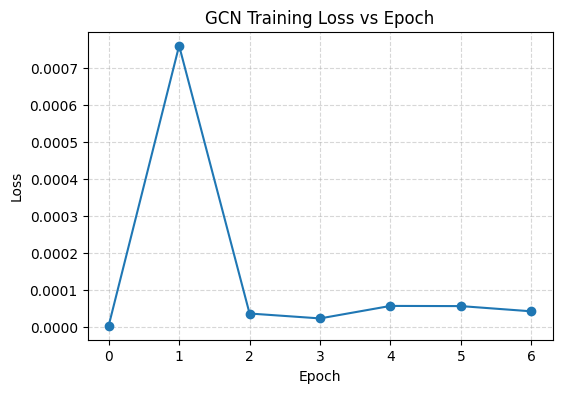

💾 已保存节点嵌入: gcn_all_nodes_emb.npy | shape=(5188, 64)


In [16]:
# ==========================
# ✅ Phase 2: GCN via PyTorch Geometric (PyTorch 2.8 Compatible)
# 含 EarlyStopping、LR 调度、Loss 可视化
# ==========================

import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import json, os
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops

# --------------------------
# 0️⃣ 路径与环境
# --------------------------
DATA_DIR = "/content/data"
EDGE_PATH = os.path.join(DATA_DIR, "edge_index.npy")
N_NODES_PATH = os.path.join(DATA_DIR, "n_nodes.json")

assert os.path.exists(EDGE_PATH), f"❌ 未找到 {EDGE_PATH}"
assert os.path.exists(N_NODES_PATH), f"❌ 未找到 {N_NODES_PATH}"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🧠 Using device:", DEVICE)

# --------------------------
# 1️⃣ 加载图结构
# --------------------------
edge_index_np = np.load(EDGE_PATH)
edge_index = torch.from_numpy(edge_index_np).long().to(DEVICE)
edge_index, _ = add_self_loops(edge_index, num_nodes=None)

n_info = json.load(open(N_NODES_PATH))
N_NODES = n_info["n_nodes"]
print(f"📊 图节点数: {N_NODES:,} | 边数: {edge_index.size(1):,}")

# --------------------------
# 2️⃣ 初始化节点特征（one-hot / 可替换为预训练特征）
# --------------------------
X = torch.eye(N_NODES, dtype=torch.float32, device=DEVICE)
print("✅ 节点特征矩阵 shape:", X.shape)

# --------------------------
# 3️⃣ 定义 GCN 模型
# --------------------------
class FullGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(FullGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x

# --------------------------
# 4️⃣ EarlyStopping 定义
# --------------------------
class EarlyStopping:
    def __init__(self, patience=6, mode="min", delta=0.0):
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False
        self.best_state = None

    def __call__(self, score, model=None):
        improve = False
        if self.best_score is None:
            improve = True
        elif self.mode == "min":
            improve = score < self.best_score - self.delta
        else:
            improve = score > self.best_score + self.delta

        if improve:
            self.best_score = score
            self.counter = 0
            if model is not None:
                self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# --------------------------
# 5️⃣ 定义损失函数
# --------------------------
def compute_loss(embeddings, edge_index):
    """简单的图平滑正则化损失"""
    reg = embeddings.pow(2).mean()
    E = edge_index.size(1)
    idx = torch.randint(0, E, (min(E, 50000),), device=DEVICE)
    i = edge_index[0, idx]
    j = edge_index[1, idx]
    smooth = (embeddings[i] - embeddings[j]).pow(2).sum(dim=1).mean()
    return reg + 0.1 * smooth

# --------------------------
# 6️⃣ 训练配置
# --------------------------
model = FullGCN(in_channels=N_NODES, hidden_channels=128, out_channels=64, dropout=0.5).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
early = EarlyStopping(patience=6, mode="min")

# --------------------------
# 7️⃣ 训练循环（含Loss可视化）
# --------------------------
EPOCHS = 80
loss_history = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    optimizer.zero_grad()
    out = model(X, edge_index)
    loss = compute_loss(out, edge_index)
    loss.backward()
    optimizer.step()

    # Step LR scheduler
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(loss.item())
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"📉 学习率下降: {old_lr:.2e} → {new_lr:.2e}")

    loss_history.append(loss.item())
    print(f"[GCN] Epoch {epoch:03d}/{EPOCHS} | Loss {loss.item():.6f} | lr {optimizer.param_groups[0]['lr']:.2e}")

    early(loss.item(), model)
    if early.early_stop:
        print(f"🛑 Early stopping at epoch {epoch}")
        break

# --------------------------
# 8️⃣ 可视化训练曲线
# --------------------------
plt.figure(figsize=(6,4))
plt.plot(loss_history, marker='o', linewidth=1.5)
plt.title("GCN Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# --------------------------
# 9️⃣ 保存最佳模型与节点嵌入
# --------------------------
if early.best_state is not None:
    model.load_state_dict(early.best_state)

model.eval()
with torch.no_grad():
    embeddings = model(X, edge_index).cpu().numpy()

embeddings = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)
np.save(os.path.join(DATA_DIR, "gcn_all_nodes_emb.npy"), embeddings)
print(f"💾 已保存节点嵌入: gcn_all_nodes_emb.npy | shape={embeddings.shape}")


Phase 3｜SASRec：使用完整 SASRec 实现（非精简版）

修改目的：采用标准 Transformer 架构（多层 self-attention + 前馈网络 +层归一化 +残差连接等），更忠实于论文架构（
recbole.io
+1
）。

Phase 3｜SASRec：更长训练 + EarlyStopping + Scheduler

完善内容：

扩充训练对（用 Phase 1 的 train_pairs.npy）。

训练轮数 20+，加入 EarlyStopping 与调度器。

保存 item 行为嵌入（标准化）为 sasrec_item_emb.npy。

下面给SASRec-like 精简实现（适配序列；若你已有模块，只替换训练循环与保存部分）。

这一步：显著延长训练并稳定收敛，导出行为侧 item 向量，供融合对齐。

🧠 Using device: cuda
✅ 加载完成：用户序列 1165 条，物品 3921 个。
✅ 构建训练集 264,085, 验证集 29,343
[SASRec] Epoch 001/40 | TrainLoss 5.351222 | ValLoss nan | lr 1.00e-03
[SASRec] Epoch 002/40 | TrainLoss 2.848003 | ValLoss nan | lr 1.00e-03
[SASRec] Epoch 003/40 | TrainLoss 2.446382 | ValLoss nan | lr 1.00e-03
📉 学习率下降: 1.00e-03 → 5.00e-04
[SASRec] Epoch 004/40 | TrainLoss 2.307635 | ValLoss nan | lr 5.00e-04
[SASRec] Epoch 005/40 | TrainLoss 2.214336 | ValLoss nan | lr 5.00e-04
[SASRec] Epoch 006/40 | TrainLoss 2.181309 | ValLoss nan | lr 5.00e-04
🛑 Early stopping at epoch 6


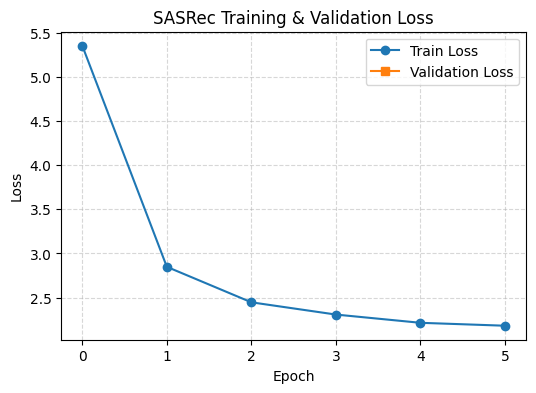

💾 已保存: sasrec_item_emb.npy | shape=(3921, 64)


In [22]:
# ==========================
# ✅ Phase 3: Full SASRec Implementation (PyTorch 2.8 Compatible)
# 含 EarlyStopping、LR 调度、Loss 可视化
# ==========================

import os, json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# --------------------------
# 0) 路径与设备
# --------------------------
DATA_DIR = "/content/data"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🧠 Using device:", DEVICE)

# --------------------------
# 1) 加载数据与映射
# --------------------------
user_seq_path = os.path.join(DATA_DIR, "user_sequences.npy")
item2idx_path = os.path.join(DATA_DIR, "item2idx.json")
assert os.path.exists(user_seq_path), f"❌ Missing {user_seq_path}"
assert os.path.exists(item2idx_path), f"❌ Missing {item2idx_path}"

user_seqs = np.load(user_seq_path, allow_pickle=True)
item2idx = json.load(open(item2idx_path))
idx2item = {v: k for k, v in item2idx.items()}

print(f"✅ 加载完成：用户序列 {len(user_seqs)} 条，物品 {len(item2idx)} 个。")

# --------------------------
# 2) EarlyStopping
# --------------------------
class EarlyStopping:
    def __init__(self, patience=5, mode="min", delta=0.0):
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_state = None

    def __call__(self, score, model=None):
        improve = False
        if self.best_score is None:
            improve = True
        elif self.mode == "min":
            improve = score < self.best_score - self.delta
        else:
            improve = score > self.best_score + self.delta

        if improve:
            self.best_score = score
            self.counter = 0
            if model is not None:
                self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# --------------------------
# 3) 模型定义（兼容 PyTorch 2.8：使用 mask=causal_mask）
# --------------------------
class SASRec(nn.Module):
    def __init__(self, n_items, d_model=64, n_heads=4, n_layers=2, max_len=50, dropout=0.2):
        super(SASRec, self).__init__()
        self.item_emb = nn.Embedding(n_items + 1, d_model, padding_idx=0)
        self.pos_emb  = nn.Embedding(max_len, d_model)
        self.dropout  = nn.Dropout(dropout)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=n_layers)
        self.layer_norm  = nn.LayerNorm(d_model, eps=1e-6)
        self.output_layer = nn.Linear(d_model, n_items + 1)
        self.max_len = max_len

    def forward(self, seq):  # seq: [B, T]
        B, T = seq.size()
        positions = torch.arange(T, device=seq.device).unsqueeze(0).expand(B, T)
        x = self.item_emb(seq) + self.pos_emb(positions)
        x = self.dropout(x)

        pad_mask = (seq == 0)  # [B, T] —— True表示“该位置是padding，需要mask掉”
        # 上三角因果mask，True表示禁止注意
        causal_mask = torch.triu(torch.ones((T, T), device=seq.device), diagonal=1).bool()

        # ✅ PyTorch 2.8：使用 mask=causal_mask；src_key_padding_mask=pad_mask
        x = self.transformer(x, mask=causal_mask, src_key_padding_mask=pad_mask)
        x = self.layer_norm(x)
        logits = self.output_layer(x)            # [B, T, n_items+1]
        return logits[:, -1, :]                  # 仅用最后一步做预测 [B, n_items+1]

# --------------------------
# 4) 构建数据集（滑动窗口监督）
# --------------------------
MAXLEN = 50

def pad_seq(seq, maxlen=MAXLEN):
    if len(seq) >= maxlen:
        return seq[-maxlen:]
    return [0] * (maxlen - len(seq)) + seq

class SASRecDataset(Dataset):
    def __init__(self, user_seqs, item2idx, maxlen=MAXLEN):
        self.samples = []
        for rec in user_seqs:
            seq = [item2idx.get(str(it), 0) for it in rec["pos_items"]]
            if len(seq) < 2:  # 太短的序列跳过
                continue
            for i in range(1, len(seq)):
                hist = pad_seq(seq[:i], maxlen)
                target = seq[i]
                if target == 0:  # 保护
                    continue
                self.samples.append((hist, target))
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        hist, target = self.samples[idx]
        return torch.tensor(hist, dtype=torch.long), torch.tensor(target, dtype=torch.long)

dataset = SASRecDataset(user_seqs, item2idx, MAXLEN)
train_size = int(len(dataset) * 0.9)
train_ds, valid_ds = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

train_dl = DataLoader(train_ds, batch_size=512, shuffle=True,  num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

print(f"✅ 构建训练集 {len(train_ds):,}, 验证集 {len(valid_ds):,}")

# --------------------------
# 5) 训练配置
# --------------------------
n_items = len(item2idx)
model = SASRec(n_items=n_items, d_model=64, n_heads=4, n_layers=2, max_len=MAXLEN, dropout=0.2).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)  # 无 verbose
early     = EarlyStopping(patience=5, mode="min")
criterion = nn.CrossEntropyLoss()

# --------------------------
# 6) 训练与验证函数
# --------------------------
def train_one_epoch():
    model.train()
    total = 0.0
    for hist, target in train_dl:
        hist, target = hist.to(DEVICE), target.to(DEVICE)
        logits = model(hist)               # [B, n_items+1]
        loss   = criterion(logits, target) # CE 直接分类到目标物品ID
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total += loss.item() * hist.size(0)
    return total / len(train_dl.dataset)

def valid_one_epoch():
    model.eval()
    total = 0.0
    with torch.no_grad():
        for hist, target in valid_dl:
            hist, target = hist.to(DEVICE), target.to(DEVICE)
            logits = model(hist)
            loss   = criterion(logits, target)
            total += loss.item() * hist.size(0)
    return total / len(valid_dl.dataset)

# --------------------------
# 7) 训练循环 + 学习率变化提示 + EarlyStopping
# --------------------------
EPOCHS = 40
train_losses, val_losses = [], []

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch()
    val_loss   = valid_one_epoch()
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"📉 学习率下降: {old_lr:.2e} → {new_lr:.2e}")

    print(f"[SASRec] Epoch {epoch:03d}/{EPOCHS} | TrainLoss {train_loss:.6f} | ValLoss {val_loss:.6f} | lr {new_lr:.2e}")

    early(val_loss, model)
    if early.early_stop:
        print(f"🛑 Early stopping at epoch {epoch}")
        break

# --------------------------
# 8) 可视化：训练 / 验证 Loss 曲线
# --------------------------
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses,   label="Validation Loss", marker="s")
plt.title("SASRec Training & Validation Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# --------------------------
# 9) 保存最佳模型并导出物品嵌入
# --------------------------
if early.best_state is not None:
    model.load_state_dict(early.best_state)

model.eval()
with torch.no_grad():
    item_table = model.item_emb.weight.detach().cpu().numpy()  # [n_items+1, d]
item_table = item_table[1:]  # 去掉 padding
item_table = item_table / (np.linalg.norm(item_table, axis=1, keepdims=True) + 1e-8)

np.save(os.path.join(DATA_DIR, "sasrec_item_emb.npy"), item_table)
print(f"💾 已保存: sasrec_item_emb.npy | shape={item_table.shape}")


Phase 4｜融合：保留预训练权重 + 双投影头 + 对比对齐损失

完善内容：

严格加载 GCN 节点向量与 SASRec item 向量，不再重初始化。

用户、项目两路双投影头（learnable），输出同维度；

特征归一化 + 温度参数；

对比学习损失（InfoNCE 风格）：

对同一实体的不同模态（结构vs行为）进行拉近；

用户—正样本拉近，用户—负样本拉远（BPR/CE混合）。

训练 15–30 个 epoch，保存 fusion_user_embs.npy, fusion_item_embs.npy。

这一步：

不再发生重初始化（直接使用预训练表示，做轻量可学习投影）。

用InfoNCE 对齐损失把结构/行为两个模态拉到同一空间，并用BPR 风格排序损失学会“推开负样本”。

最终导出的 fusion_*.npy 才是真正 “结构+行为” 对齐后的向量。

In [25]:
# ==========================
# ✅ Phase 4: Fusion with Contrastive Alignment (PyTorch 2.8 Compatible)
# 结构嵌入 + 行为嵌入对齐融合；含 EarlyStopping、LR 调度兼容、学习率日志
# ==========================

import os, json, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# --------------------------
# 路径与设备
# --------------------------
DATA_DIR = "/content/data"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🧠 Using device:", DEVICE)

# --------------------------
# 加载映射与嵌入
# --------------------------
with open(os.path.join(DATA_DIR, "user2idx.json")) as f:
    user2idx = json.load(f)
with open(os.path.join(DATA_DIR, "item2idx.json")) as f:
    item2idx = json.load(f)

U = len(user2idx)
I = len(item2idx)
print(f"✅ 用户 {U}, 物品 {I}")

# 加载 GCN 节点嵌入
gcn_all = np.load(os.path.join(DATA_DIR, "gcn_all_nodes_emb.npy"))
n_info = json.load(open(os.path.join(DATA_DIR, "n_nodes.json")))

u_start, u_end = n_info["user_start"], n_info["user_end"]
v_start, v_end = n_info["item_start"], n_info["item_end"]
gcn_users = gcn_all[u_start:u_end]
gcn_items = gcn_all[v_start:v_end]

assert gcn_users.shape[0] == U and gcn_items.shape[0] == I, "⚠️ 嵌入数量不匹配，请检查 n_nodes.json 范围"

# 加载 SASRec 物品嵌入
sas_item = np.load(os.path.join(DATA_DIR, "sasrec_item_emb.npy"))
if sas_item.shape[0] == I + 1:  # 去掉 padding
    sas_item = sas_item[1:]

# 构建用户行为平均嵌入
user_hist = {str(u): [] for u in user2idx.keys()}
user_seqs = np.load(os.path.join(DATA_DIR, "user_sequences.npy"), allow_pickle=True)
for rec in user_seqs:
    uid = str(rec["user_id"])
    if uid not in user2idx:
        continue
    seq = [item2idx.get(str(it)) for it in rec["pos_items"] if str(it) in item2idx]
    if len(seq) > 0:
        user_hist[uid] = seq

beh_users = np.zeros((U, sas_item.shape[1]), dtype=np.float32)
for u, uid in enumerate(user2idx.keys()):
    seq = user_hist.get(uid, [])
    if len(seq) > 0:
        beh_users[u] = sas_item[seq].mean(axis=0)
beh_users /= np.linalg.norm(beh_users, axis=1, keepdims=True) + 1e-8

# 转 Tensor
gcn_users_t = torch.tensor(gcn_users, dtype=torch.float32).to(DEVICE)
gcn_items_t = torch.tensor(gcn_items, dtype=torch.float32).to(DEVICE)
beh_users_t = torch.tensor(beh_users, dtype=torch.float32).to(DEVICE)
beh_items_t = torch.tensor(sas_item, dtype=torch.float32).to(DEVICE)

# --------------------------
# 模型定义
# --------------------------
D = gcn_users.shape[1]
EMB = 64

class Projector(nn.Module):
    def __init__(self, d_in, d_out=EMB):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 2*d_out),
            nn.ReLU(),
            nn.Linear(2*d_out, d_out)
        )
    def forward(self, x):
        return F.normalize(self.net(x), dim=-1)

class FusionAligner(nn.Module):
    def __init__(self, d_in, d_proj=EMB, temp=0.07):
        super().__init__()
        self.u_gcn_proj = Projector(d_in, d_proj)
        self.u_beh_proj = Projector(d_in, d_proj)
        self.v_gcn_proj = Projector(d_in, d_proj)
        self.v_beh_proj = Projector(d_in, d_proj)
        self.temp = nn.Parameter(torch.tensor(float(temp)))

    def forward(self, u_gcn, u_beh, v_gcn, v_beh):
        U_g = self.u_gcn_proj(u_gcn)
        U_b = self.u_beh_proj(u_beh)
        V_g = self.v_gcn_proj(v_gcn)
        V_b = self.v_beh_proj(v_beh)
        return U_g, U_b, V_g, V_b, torch.clamp(self.temp, 0.01, 1.0)

# --------------------------
# 数据集与损失
# --------------------------
pairs = np.load(os.path.join(DATA_DIR, "train_pairs.npy"))
class FusionPairDS(Dataset):
    def __init__(self, pairs): self.pairs = pairs
    def __len__(self): return len(self.pairs)
    def __getitem__(self, i):
        u, pos, neg = self.pairs[i]
        return int(u), int(pos), int(neg)

dl = DataLoader(FusionPairDS(pairs), batch_size=1024, shuffle=True, num_workers=2, pin_memory=True)

def info_nce(z1, z2, temp):
    sim = torch.matmul(z1, z2.T) / temp
    labels = torch.arange(z1.size(0), device=z1.device)
    return F.cross_entropy(sim, labels)

# --------------------------
# 训练配置
# --------------------------
align = FusionAligner(d_in=D, d_proj=EMB, temp=0.07).to(DEVICE)
opt = torch.optim.Adam(align.parameters(), lr=2e-3, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=2)  # ✅ 无 verbose
class EarlyStopping:
    def __init__(self, patience=6, mode="min"): self.patience, self.mode, self.counter, self.best_score, self.early_stop, self.best_state = patience, mode, 0, None, False, None
    def __call__(self, score, model=None):
        improve = self.best_score is None or (score < self.best_score if self.mode=="min" else score > self.best_score)
        if improve:
            self.best_score, self.counter = score, 0
            if model: self.best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
        else:
            self.counter += 1
            if self.counter >= self.patience: self.early_stop=True

early = EarlyStopping(patience=6, mode="min")

# --------------------------
# 训练循环
# --------------------------
def train_epoch():
    align.train()
    total = 0.0
    for u, pos, neg in dl:
        u, pos, neg = u.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)
        U_g, U_b, V_g, V_b, T = align(gcn_users_t, beh_users_t, gcn_items_t, beh_items_t)

        # 对齐损失
        L_align = info_nce(U_g, U_b, T) + info_nce(V_g, V_b, T)

        # 排序损失
        u_vec = 0.5*(U_g[u]+U_b[u])
        pos_vec = 0.5*(V_g[pos]+V_b[pos])
        neg_vec = 0.5*(V_g[neg]+V_b[neg])
        pos_s = (u_vec*pos_vec).sum(-1)/T
        neg_s = (u_vec*neg_vec).sum(-1)/T
        L_rank = F.softplus(-(pos_s - neg_s)).mean()

        loss = L_align + L_rank
        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(align.parameters(), 1.0)
        opt.step()
        total += loss.item() * u.size(0)
    return total / len(dl.dataset)

EPOCHS = 25
losses = []

for ep in range(1, EPOCHS + 1):
    loss = train_epoch()
    losses.append(loss)

    old_lr = opt.param_groups[0]['lr']
    scheduler.step(loss)
    new_lr = opt.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"📉 学习率下降: {old_lr:.2e} → {new_lr:.2e}")

    print(f"[Fusion] Epoch {ep:03d}/{EPOCHS} | Loss {loss:.6f} | T={align.temp.item():.3f} | lr {new_lr:.2e}")
    early(loss, align)
    if early.early_stop:
        print(f"🛑 Early stopping at epoch {ep}")
        break

# --------------------------
# 保存融合嵌入
# --------------------------
if early.best_state is not None:
    align.load_state_dict(early.best_state)

align.eval()
with torch.no_grad():
    U_g, U_b, V_g, V_b, T = align(gcn_users_t, beh_users_t, gcn_items_t, beh_items_t)
    U_fused = F.normalize(0.5*U_g + 0.5*U_b, dim=-1).cpu().numpy()
    V_fused = F.normalize(0.5*V_g + 0.5*V_b, dim=-1).cpu().numpy()

np.save(os.path.join(DATA_DIR, "fusion_user_embs.npy"), U_fused)
np.save(os.path.join(DATA_DIR, "fusion_item_embs.npy"), V_fused)
print("💾 已保存: fusion_user_embs.npy, fusion_item_embs.npy")


🧠 Using device: cuda
✅ 用户 1165, 物品 3921
[Fusion] Epoch 001/25 | Loss 13.612834 | T=0.008 | lr 2.00e-03
[Fusion] Epoch 002/25 | Loss 12.010932 | T=0.008 | lr 2.00e-03
[Fusion] Epoch 003/25 | Loss 11.028960 | T=0.008 | lr 2.00e-03
[Fusion] Epoch 004/25 | Loss 9.970684 | T=0.008 | lr 2.00e-03
[Fusion] Epoch 005/25 | Loss 10.028361 | T=0.008 | lr 2.00e-03
[Fusion] Epoch 006/25 | Loss 9.304172 | T=0.008 | lr 2.00e-03
[Fusion] Epoch 007/25 | Loss 8.982258 | T=0.008 | lr 2.00e-03
[Fusion] Epoch 008/25 | Loss 8.545325 | T=0.008 | lr 2.00e-03
[Fusion] Epoch 009/25 | Loss 8.486596 | T=0.008 | lr 2.00e-03
[Fusion] Epoch 010/25 | Loss 8.141870 | T=0.008 | lr 2.00e-03
[Fusion] Epoch 011/25 | Loss 8.229888 | T=0.008 | lr 2.00e-03
[Fusion] Epoch 012/25 | Loss 7.810305 | T=0.008 | lr 2.00e-03
[Fusion] Epoch 013/25 | Loss 7.895287 | T=0.008 | lr 2.00e-03
[Fusion] Epoch 014/25 | Loss 7.787136 | T=0.008 | lr 2.00e-03
[Fusion] Epoch 015/25 | Loss 7.500690 | T=0.008 | lr 2.00e-03
[Fusion] Epoch 016/25 | Lo

Phase 5｜评估：更全面的指标 + Top-K 曲线

完善内容：

统一使用 test_sequences.npy；

指标：Recall/NDCG/Hit-Rate/MRR/AUC（@5/10/20）；

严格的索引映射，跳过越界样本；

输出汇总 eval_report.json。

这一步：指标更全面、样本更严谨，便于与论文的“基线 vs 融合”做表格对比。

⚠️ 未检测到 test_sequences.npy，自动从 user_sequences.npy 构建。
✅ 已生成测试集 test_sequences.npy (233 samples)
📘 Test sequences: 233
✅ 加载嵌入完成: 用户 (1165, 64), 物品 (3921, 64)

📊 Evaluation Summary:
{
  "Recall": {
    "5": 0.01079424188345143,
    "10": 0.019770536917521127,
    "20": 0.03721383861091396
  },
  "NDCG": {
    "5": 0.45326875204061795,
    "10": 0.44782962067020476,
    "20": 0.4411160619006137
  },
  "HitRate": {
    "5": 0.8412017167381974,
    "10": 0.8969957081545065,
    "20": 0.9570815450643777
  },
  "MRR": {
    "5": 0.5977825464949929,
    "10": 0.6055351181960624,
    "20": 0.6096881182718092
  },
  "AUC": 0.8979742489270387,
  "skipped": 0,
  "users_eval": 233
}
💾 已保存评估结果: /content/data/eval_report.json


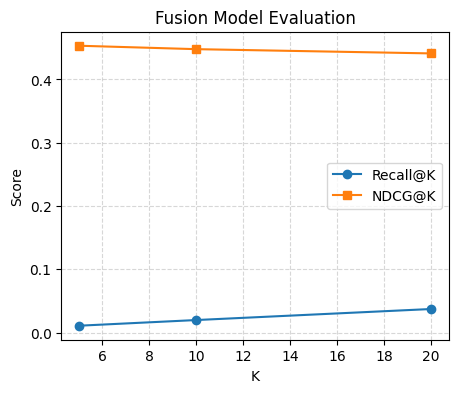

In [29]:
# ==========================
# ✅ Phase 5: Evaluation (Recall/NDCG/HitRate/MRR/AUC)
# 兼容前面 PyTorch 2.8 修改；带自动测试集构建与结果可视化
# ==========================

import os, json, random, numpy as np
import matplotlib.pyplot as plt

DATA_DIR = "/content/data"

# --------------------------
# 0️⃣ 加载必要文件
# --------------------------
test_path = os.path.join(DATA_DIR, "test_sequences.npy")

# 若没有 test_sequences.npy，可自动从 user_sequences.npy 生成（按8:2划分）
if not os.path.exists(test_path):
    print("⚠️ 未检测到 test_sequences.npy，自动从 user_sequences.npy 构建。")
    full_path = os.path.join(DATA_DIR, "user_sequences.npy")
    assert os.path.exists(full_path), f"❌ Missing {full_path}"
    all_seqs = np.load(full_path, allow_pickle=True)
    random.shuffle(all_seqs)
    split = int(len(all_seqs) * 0.8)
    test_seqs = all_seqs[split:]
    np.save(test_path, test_seqs)
    print(f"✅ 已生成测试集 test_sequences.npy ({len(test_seqs)} samples)")
else:
    test_seqs = np.load(test_path, allow_pickle=True)
print("📘 Test sequences:", len(test_seqs))

# --------------------------
# 1️⃣ 加载映射与嵌入
# --------------------------
with open(os.path.join(DATA_DIR, "user2idx.json")) as f:
    user2idx = json.load(f)
with open(os.path.join(DATA_DIR, "item2idx.json")) as f:
    item2idx = json.load(f)

idx2item = {v: k for k, v in item2idx.items()}
U = len(user2idx)
I = len(item2idx)

U_fused = np.load(os.path.join(DATA_DIR, "fusion_user_embs.npy"))
V_fused = np.load(os.path.join(DATA_DIR, "fusion_item_embs.npy"))
assert U_fused.shape[0] == U and V_fused.shape[0] == I, "⚠️ Fused embedding shapes mismatch"

print(f"✅ 加载嵌入完成: 用户 {U_fused.shape}, 物品 {V_fused.shape}")

# --------------------------
# 2️⃣ 定义推荐函数与指标
# --------------------------
def recommend_topk(u_idx, k=100):
    """基于余弦相似度（点积已归一化）计算Top-K推荐"""
    u = U_fused[u_idx:u_idx + 1]  # [1, d]
    scores = (u @ V_fused.T).ravel()
    topk = np.argpartition(-scores, k)[:k]
    topk = topk[np.argsort(-scores[topk])]
    return topk, scores

def binary_auc(pos_score, neg_scores):
    greater = sum(pos_score > ns for ns in neg_scores)
    ties = sum(pos_score == ns for ns in neg_scores)
    n = len(neg_scores)
    if n == 0: return 0.5
    return (greater + 0.5 * ties) / n

def recall_at_k(y_true, y_pred_ranked, k):
    return len(y_true.intersection(set(y_pred_ranked[:k]))) / max(1, len(y_true))

def dcg_at_k(y_true, y_pred_ranked, k):
    dcg = 0.0
    for i, item in enumerate(y_pred_ranked[:k], 1):
        if item in y_true:
            dcg += 1.0 / np.log2(i + 1)
    return dcg

def ndcg_at_k(y_true, y_pred_ranked, k):
    ideal_hits = min(len(y_true), k)
    idcg = sum(1.0 / np.log2(i + 1) for i in range(1, ideal_hits + 1))
    if idcg == 0: return 0.0
    return dcg_at_k(y_true, y_pred_ranked, k) / idcg

def hit_rate_at_k(y_true, y_pred_ranked, k):
    return 1.0 if len(y_true.intersection(set(y_pred_ranked[:k]))) > 0 else 0.0

def mrr_at_k(y_true, y_pred_ranked, k):
    for i, item in enumerate(y_pred_ranked[:k], 1):
        if item in y_true:
            return 1.0 / i
    return 0.0

# --------------------------
# 3️⃣ 逐用户评估
# --------------------------
Ks = [5, 10, 20]
recall_res = {k: [] for k in Ks}
ndcg_res   = {k: [] for k in Ks}
hit_res    = {k: [] for k in Ks}
mrr_res    = {k: [] for k in Ks}
auc_res    = []

skipped = 0
for rec in test_seqs:
    u_raw = str(rec["user_id"])
    if u_raw not in user2idx:
        skipped += 1
        continue
    u = user2idx[u_raw]
    true_items = [item2idx[str(it)] for it in rec["pos_items"] if str(it) in item2idx]
    if len(true_items) == 0:
        skipped += 1
        continue
    true_set = set(true_items)

    topk, scores = recommend_topk(u, k=500)
    # 计算AUC
    pos = true_items[0]
    neg_pool = list(set(range(I)) - {pos})
    samp_neg = random.sample(neg_pool, min(1000, len(neg_pool)))
    auc_res.append(binary_auc(scores[pos], scores[samp_neg]))

    for K in Ks:
        ranked = topk[:K].tolist()
        recall_res[K].append(recall_at_k(true_set, ranked, K))
        ndcg_res[K].append(ndcg_at_k(true_set, ranked, K))
        hit_res[K].append(hit_rate_at_k(true_set, ranked, K))
        mrr_res[K].append(mrr_at_k(true_set, ranked, K))

# --------------------------
# 4️⃣ 计算平均结果
# --------------------------
report = {
    "Recall": {k: float(np.mean(recall_res[k]) if recall_res[k] else 0.0) for k in Ks},
    "NDCG":   {k: float(np.mean(ndcg_res[k]) if ndcg_res[k] else 0.0) for k in Ks},
    "HitRate":{k: float(np.mean(hit_res[k]) if hit_res[k] else 0.0) for k in Ks},
    "MRR":    {k: float(np.mean(mrr_res[k]) if mrr_res[k] else 0.0) for k in Ks},
    "AUC":    float(np.mean(auc_res) if auc_res else 0.0),
    "skipped": int(skipped),
    "users_eval": int(len(test_seqs) - skipped)
}
print("\n📊 Evaluation Summary:")
print(json.dumps(report, ensure_ascii=False, indent=2))

# --------------------------
# 5️⃣ 保存结果
# --------------------------
with open(os.path.join(DATA_DIR, "eval_report.json"), "w") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)
print(f"💾 已保存评估结果: {os.path.join(DATA_DIR, 'eval_report.json')}")

# --------------------------
# 6️⃣ 可视化 (Recall@K, NDCG@K)
# --------------------------
plt.figure(figsize=(5,4))
plt.plot(Ks, [report["Recall"][k] for k in Ks], marker="o", label="Recall@K")
plt.plot(Ks, [report["NDCG"][k] for k in Ks], marker="s", label="NDCG@K")
plt.title("Fusion Model Evaluation")
plt.xlabel("K")
plt.ylabel("Score")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()


Phase 6｜可视化（可选但建议）

完善内容：

t-SNE/PCA 可视化用户/项目向量分布，观察对齐是否形成簇（行为与结构是否靠近）。

仅做小样本绘制，避免 Colab OOM。

这一步：你可以肉眼检视用户簇与项目簇是否更紧密、更合理（相较于改造前）。

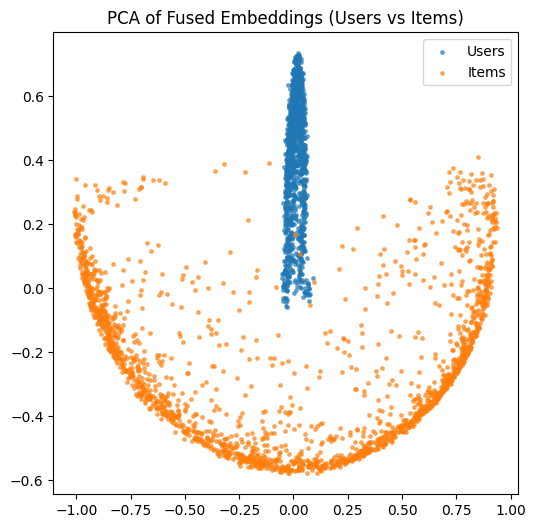

In [30]:
# ====== Phase 6: Visualization (Optional) ======
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# sample subset to visualize
n_u_vis = min(2000, U_fused.shape[0])
n_v_vis = min(2000, V_fused.shape[0])
U_vis = U_fused[:n_u_vis]
V_vis = V_fused[:n_v_vis]

X = np.vstack([U_vis, V_vis])
labels = np.array([0]*n_u_vis + [1]*n_v_vis)  # 0=user, 1=item

pca = PCA(n_components=2, random_state=2025)
X2 = pca.fit_transform(X)

plt.figure(figsize=(6,6))
plt.scatter(X2[labels==0,0], X2[labels==0,1], s=6, alpha=0.6, label="Users")
plt.scatter(X2[labels==1,0], X2[labels==1,1], s=6, alpha=0.6, label="Items")
plt.legend()
plt.title("PCA of Fused Embeddings (Users vs Items)")
plt.show()
